### XGBoost training on mutational and genomic data

In [139]:
# import python packages
import shap
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import metrics, calibration
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

In [140]:
# allow multiple outputs of a cell to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [141]:
import os
os.chdir('/home/projects/aafek/nogal/noga_project/AI_hub/Repair-mutation project/Data')

In [4]:
# load data:
df_clean = pd.read_csv('mutations_TDG_genomic_processed.csv')
df_clean

,sequence_context,seqnames,start,PhyloP_score,is_CpG,experimental_ln_FI,label_counts,gene_type_TEC,gene_type_lncRNA,gene_type_miRNA,...,ccre_type_DNase-H3K4me3,"ccre_type_DNase-H3K4me3,CTCF-bound",ccre_type_PLS,"ccre_type_PLS,CTCF-bound",ccre_type_dELS,"ccre_type_dELS,CTCF-bound",ccre_type_pELS,"ccre_type_pELS,CTCF-bound",is_protein_coding,MAF_log
0,AACAAAA,1,99267131,-0.055,0,7.090493,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-4.829928
1,AACAAAA,1,161294824,-1.399,0,7.090493,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-8.518194
2,AACAAAA,1,169903374,-1.708,0,7.090493,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-7.825297
3,AACAAAA,1,82064640,-0.639,0,7.090493,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-8.518194
4,AACAAAA,1,153830104,-1.016,0,7.090493,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-7.825297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40665,TTCTTTT,1,156911602,-0.868,0,6.576470,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-3.874241
40666,TTCTTTT,1,26226773,-1.496,0,6.576470,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-0.760356
40667,TTCTTTT,1,229773166,0.243,0,6.576470,10,False,False,False,...,False,False,False,False,False,False,False,False,1,-8.518194
40668,TTCTTTT,1,106091814,-1.192,0,6.576470,10,False,True,False,...,False,False,False,False,False,False,False,False,1,-1.221119


### Predict MAF

define features and labels

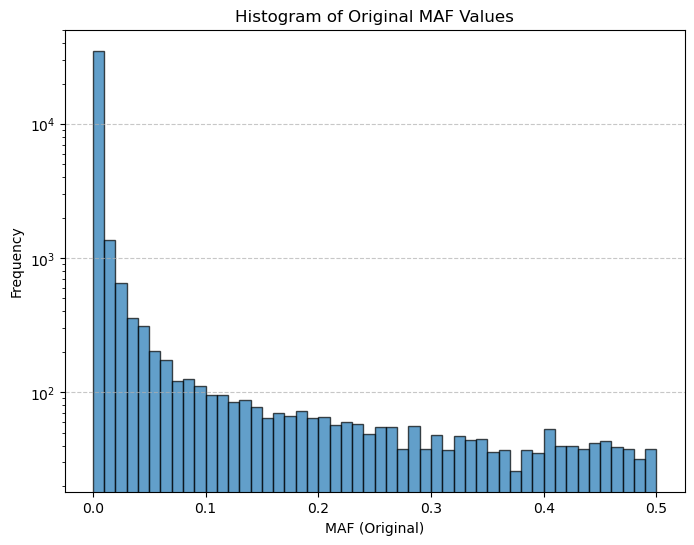

In [5]:
# Convert log MAF to original MAF
df_clean["MAF_original"] = np.exp(df_clean["MAF_log"])

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(df_clean["MAF_original"], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("MAF (Original)")
plt.ylabel("Frequency")
plt.title("Histogram of Original MAF Values")
plt.yscale("log")  # Log scale for better visualization of distribution
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show();

In [6]:
df_clean["bMAF"] = df_clean.MAF_original > 0.1

In [7]:
# Define features:
feature_names = ['is_CpG','is_protein_coding', 'experimental_ln_FI']
one_hot_feature_names = df_clean.columns[7:31].tolist()
all_features = feature_names + one_hot_feature_names  # Combine named & indexed features
all_features

['is_CpG',
 'is_protein_coding',
 'experimental_ln_FI',
 'gene_type_TEC',
 'gene_type_lncRNA',
 'gene_type_miRNA',
 'gene_type_misc_RNA',
 'gene_type_polymorphic_pseudogene',
 'gene_type_processed_pseudogene',
 'gene_type_protein_coding',
 'gene_type_rRNA_pseudogene',
 'gene_type_snRNA',
 'gene_type_snoRNA',
 'gene_type_transcribed_processed_pseudogene',
 'gene_type_transcribed_unitary_pseudogene',
 'gene_type_transcribed_unprocessed_pseudogene',
 'gene_type_unitary_pseudogene',
 'gene_type_unprocessed_pseudogene',
 'ccre_type_CTCF-only,CTCF-bound',
 'ccre_type_DNase-H3K4me3',
 'ccre_type_DNase-H3K4me3,CTCF-bound',
 'ccre_type_PLS',
 'ccre_type_PLS,CTCF-bound',
 'ccre_type_dELS',
 'ccre_type_dELS,CTCF-bound',
 'ccre_type_pELS',
 'ccre_type_pELS,CTCF-bound']

In [8]:
# change one hot to int:
feature_indexes = list(range(7, 32))   # for one hot encoded
df_clean.iloc[:, feature_indexes] = df_clean.iloc[:, feature_indexes].astype(int)
df_clean

,sequence_context,seqnames,start,PhyloP_score,is_CpG,experimental_ln_FI,label_counts,gene_type_TEC,gene_type_lncRNA,gene_type_miRNA,...,"ccre_type_PLS,CTCF-bound",ccre_type_dELS,"ccre_type_dELS,CTCF-bound",ccre_type_pELS,"ccre_type_pELS,CTCF-bound",is_protein_coding,MAF_log,MAF_original,bPhylop,bMAF
0,AACAAAA,1,99267131,-0.055,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-4.829928,0.007987,True,False
1,AACAAAA,1,161294824,-1.399,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-8.518194,0.000200,True,False
2,AACAAAA,1,169903374,-1.708,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-7.825297,0.000400,True,False
3,AACAAAA,1,82064640,-0.639,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-8.518194,0.000200,True,False
4,AACAAAA,1,153830104,-1.016,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-7.825297,0.000400,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40665,TTCTTTT,1,156911602,-0.868,0,6.576470,10,0,0,0,...,0,0,0,0,0,1,-3.874241,0.020770,True,False
40666,TTCTTTT,1,26226773,-1.496,0,6.576470,10,0,0,0,...,0,0,0,0,0,1,-0.760356,0.467500,True,True
40667,TTCTTTT,1,229773166,0.243,0,6.576470,10,0,0,0,...,0,0,0,0,0,1,-8.518194,0.000200,True,False
40668,TTCTTTT,1,106091814,-1.192,0,6.576470,10,0,1,0,...,0,0,0,0,0,1,-1.221119,0.294900,True,True


In [9]:
X = df_clean[all_features]
y = df_clean['bMAF']  
#X, y

In [10]:
# Find binary (one-hot encoded) columns
binary_columns = [col for col in df_clean.columns if df_clean[col].nunique() == 2]

# Count 0s and 1s for each binary column
binary_distribution = df_clean[binary_columns].apply(lambda x: x.value_counts())

print("Binary Feature Distribution (0/1 counts):")
print(binary_distribution)

Binary Feature Distribution (0/1 counts):
   is_CpG  gene_type_TEC  gene_type_lncRNA  gene_type_miRNA  \
0   39750          40658             34974            40666   
1     920             12              5696                4   

   gene_type_misc_RNA  gene_type_polymorphic_pseudogene  \
0               40663                             40655   
1                   7                                15   

   gene_type_processed_pseudogene  gene_type_protein_coding  \
0                           40483                     21148   
1                             187                     19522   

   gene_type_rRNA_pseudogene  gene_type_snRNA  ...  ccre_type_DNase-H3K4me3  \
0                      40668            40666  ...                    40582   
1                          2                4  ...                       88   

   ccre_type_DNase-H3K4me3,CTCF-bound  ccre_type_PLS  \
0                               40623          40598   
1                                  47             

In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score 

Train-test

In [12]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [13]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (32536, 27)
y_train shape: (32536,)


In [14]:
# Count True and False values in df_clean['bMAF']
true_count = df_clean['bMAF'].sum()  # Sum of True values (since True = 1, False = 0)
false_count = len(df_clean) - true_count  # Total rows minus True count

# Print results
print(f"True count: {true_count}")
print(f"False count: {false_count}")

True count: 2103
False count: 38567


In [28]:
print(df_clean['bMAF'].value_counts())

bMAF
False    37833
True      2837
Name: count, dtype: int64


In [15]:
ratio = len(df_clean[df_clean['bMAF'] == False]) / len(df_clean[df_clean['bMAF'] == True])  
model = XGBClassifier(random_state=42,
                      scale_pos_weight=ratio)  # Adjust weight dynamically

In [16]:
ratio

18.339039467427483

In [17]:
# Train the model
model.fit(X_train, y_train)

# Predict probabilities & binary class labels
y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
y_pred = model.predict(X_test)  # Get binary predictions

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# Print classification report
print(classification_report(y_test, y_pred))

# Compute AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

       False       0.95      0.87      0.91      7713
        True       0.05      0.12      0.07       421

    accuracy                           0.83      8134
   macro avg       0.50      0.50      0.49      8134
weighted avg       0.90      0.83      0.87      8134

AUC-ROC Score: 0.4973


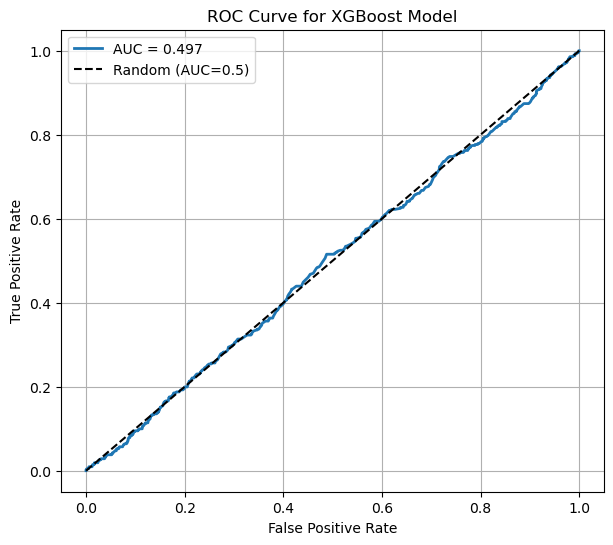

In [19]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend()
plt.grid()
plt.show();

In [20]:
import pickle
import json
import os
from sklearn.metrics import roc_curve, auc

# Define a dictionary to store all model details
model_results = {}

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Store results in dictionary
model_name = "MAF_t0.1_NoGrid"  # Change this for different models
model_results[model_name] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": roc_auc}

# Save as a JSON file
results_file = "MAF_t0.1_NoGrid_roc.json"


with open(results_file, "w") as f:
    json.dump(model_results, f, indent=4)
    
print(f"ROC details for {model_name} saved successfully!")


ROC details for MAF_t0.1_NoGrid saved successfully!


### different MAF threshold

In [44]:
df_clean["bMAF"] = df_clean.MAF_original > 0.05

In [45]:
X = df_clean[all_features]
y = df_clean['bMAF']  
#X, y

Train-test

In [46]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [47]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (32536, 27)
y_train shape: (32536,)


In [48]:
# Count True and False values in df_clean['bMAF']
true_count = df_clean['bMAF'].sum()  # Sum of True values (since True = 1, False = 0)
false_count = len(df_clean) - true_count  # Total rows minus True count

# Print results
print(f"True count: {true_count}")
print(f"False count: {false_count}")

True count: 2837
False count: 37833


In [49]:
print(df_clean['bMAF'].value_counts())

bMAF
False    37833
True      2837
Name: count, dtype: int64


In [50]:
# Take the majority class and divide by minority:
ratio = len(df_clean[df_clean['bMAF'] == False]) / len(df_clean[df_clean['bMAF'] == True])  
model = XGBClassifier(random_state=42,
                      scale_pos_weight=ratio)  # Adjust weight dynamically

In [51]:
ratio

13.335565738456115

In [37]:
# Train the model
model.fit(X_train, y_train)

# Predict probabilities & binary class labels
y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
y_pred = model.predict(X_test)  # Get binary predictions

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# Print classification report
print(classification_report(y_test, y_pred))

# Compute AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

       False       0.93      0.87      0.90      7567
        True       0.08      0.16      0.11       567

    accuracy                           0.82      8134
   macro avg       0.51      0.51      0.50      8134
weighted avg       0.87      0.82      0.84      8134

AUC-ROC Score: 0.5148


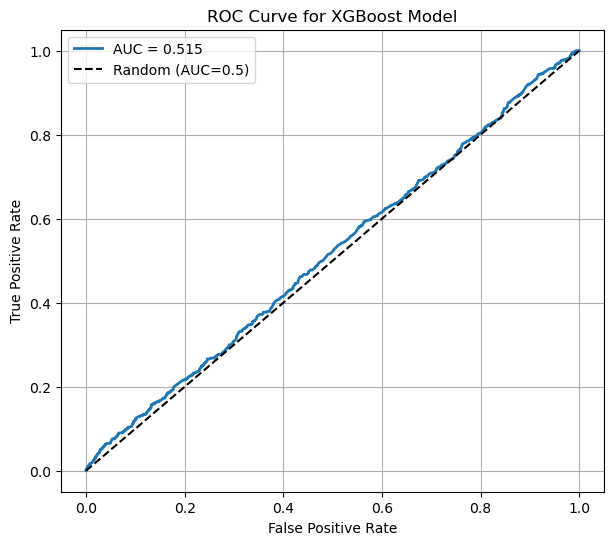

In [39]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend()
plt.grid()
plt.show();

In [40]:
# Store results in dictionary
model_name = "MAF_t0.05_NoGrid"  # Change this for different models
model_results[model_name] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": roc_auc}

# Save as a JSON file
results_file = "MAF_t0.05_NoGrid.json"

with open(results_file, "w") as f:
    json.dump(model_results, f, indent=4)
    
print(f"ROC details for {model_name} saved successfully!")

ROC details for MAF_t0.05_NoGrid saved successfully!


### balanced MAF threshold

In [181]:
df_clean["bMAF"] = df_clean.MAF_original > 0.001

In [182]:
X = df_clean[all_features]
y = df_clean['bMAF']  
#X, y

Train-test

In [183]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [184]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (32536, 27)
y_train shape: (32536,)


In [185]:
# Count True and False values in df_clean['bMAF']
true_count = df_clean['bMAF'].sum()  # Sum of True values (since True = 1, False = 0)
false_count = len(df_clean) - true_count  # Total rows minus True count

# Print results
print(f"True count: {true_count}")
print(f"False count: {false_count}")

True count: 13044
False count: 27626


In [186]:
print(df_clean['bMAF'].value_counts())

bMAF
False    27626
True     13044
Name: count, dtype: int64


In [187]:
# Take the majority class and divide by minority:
ratio = len(df_clean[df_clean['bMAF'] == False]) / len(df_clean[df_clean['bMAF'] == True])  
model = XGBClassifier(random_state=42,
                      scale_pos_weight=ratio)  # Adjust weight dynamically

In [188]:
ratio

2.117908616988654

In [189]:
# Train the model
model.fit(X_train, y_train)

# Predict probabilities & binary class labels
y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
y_pred = model.predict(X_test)  # Get binary predictions

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [190]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# Print classification report
print(classification_report(y_test, y_pred))

# Compute AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

       False       0.68      0.61      0.65      5525
        True       0.33      0.40      0.36      2609

    accuracy                           0.54      8134
   macro avg       0.51      0.51      0.50      8134
weighted avg       0.57      0.54      0.55      8134

AUC-ROC Score: 0.5110


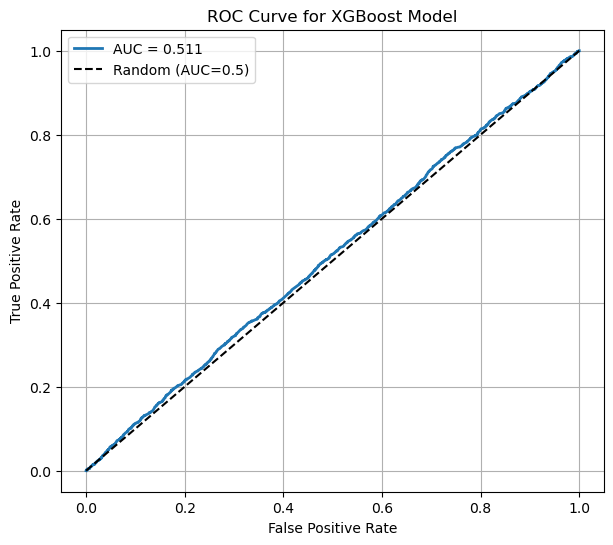

In [191]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend()
plt.grid()
plt.show();

In [192]:
# Store results in dictionary
model_name = "MAF_t0.001_NoGrid"  # Change this for different models
model_results[model_name] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": roc_auc}

# Save as a JSON file
results_file = "MAF_t0.001_NoGrid.json"

with open(results_file, "w") as f:
    json.dump(model_results, f, indent=4)
    
print(f"ROC details for {model_name} saved successfully!")

ROC details for MAF_t0.001_NoGrid saved successfully!


### Grid search

In [52]:
df_clean["bMAF"] = df_clean.MAF_original > 0.05

In [53]:
X = df_clean[all_features]
y = df_clean['bMAF']  
#X, y

Train-test

In [54]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [55]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (32536, 27)
y_train shape: (32536,)


In [56]:
# Count True and False values in df_clean['bMAF']
true_count = df_clean['bMAF'].sum()  # Sum of True values (since True = 1, False = 0)
false_count = len(df_clean) - true_count  # Total rows minus True count

# Print results
print(f"True count: {true_count}")
print(f"False count: {false_count}")

True count: 2837
False count: 37833


In [57]:
# Take the majority class and divide by minority:
ratio = len(df_clean[df_clean['bMAF'] == True]) / len(df_clean[df_clean['bMAF'] == False])  
model = XGBClassifier(random_state=42,
                      scale_pos_weight=ratio)  # Adjust weight dynamically

In [58]:
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'max_depth': [3, 5, 7],             # Tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Step size for each tree
    'subsample': [0.8, 1.0],            # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],     # Fraction of features used per tree
    'reg_alpha': [0, 0.1, 1],           # L1 regularization?
    'reg_lambda': [1, 10],              # L2 regularization?
}

In [59]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=3,                             # 5-fold cross-validation
    verbose=3,                        # Verbosity level for progress updates
    n_jobs=-1                         # Use all available CPUs
)

In [60]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                   n_iter=100, cv=3, verbose=1, n_jobs=-1)

In [61]:
# Fit the Randomized Search model to training data
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 10],
                                        'subsample': [0.8, 1.0]},
                   verbose=1)

In [62]:
# Print the best parameters found
print("Best hyperparameters:", random_search.best_params_)
best_model = random_search.best_estimator_

Best hyperparameters: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


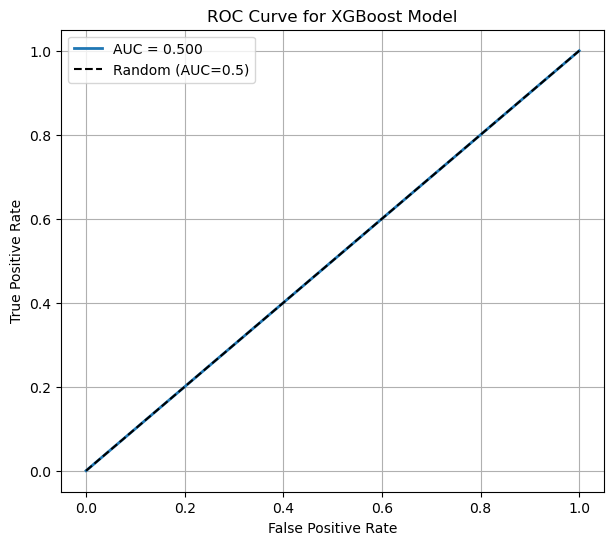

In [63]:
# Train the model
best_model.fit(X_train, y_train)

y_pred_probs = best_model.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend()
plt.grid()
plt.show();

### Running best hyper parameters on 3 different threshold

In [64]:
thresholds = [0.05, 0.1, 0.2]  # Define your thresholds
results = []  # To store evaluation metrics
roc_data = {}  # To store ROC curves for each threshold

for threshold in thresholds:
    print(f"\nRunning classifier for threshold: {threshold}")
    
    # Create binary labels
    df_clean['bMAF'] = (df_clean['MAF_original'] >= threshold).astype(int)
    df = df_clean.dropna(subset=['bMAF']).copy()

    X = df[all_features]
    y = df["bMAF"].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train XGBoost classifier
    model = XGBClassifier(
        subsample= 0.8, 
        reg_lambda= 10, 
        reg_alpha= 0.1, n_estimators= 100, 
        max_depth= 7, learning_rate= 0.01, colsample_bytree= 1.0,
        scale_pos_weight=len(df_clean[df_clean['bMAF'] == True]) / len(df_clean[df_clean['bMAF'] == False])   # Adjust for imbalance
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    roc_auc = auc(*roc_curve(y_test, y_pred_prob)[:2])
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report["accuracy"]
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    results.append([threshold, roc_auc, accuracy, precision, recall])
    roc_data[threshold] = roc_curve(y_test, y_pred_prob)
    
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Threshold", "AUC", "Accuracy", "Precision", "Recall"])


Running classifier for threshold: 0.05


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Running classifier for threshold: 0.1


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Running classifier for threshold: 0.2


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [65]:
results_df

,Threshold,AUC,Accuracy,Precision,Recall
0,0.05,0.5,0.930293,0.0,0.0
1,0.10,0.5,0.948242,0.0,0.0
2,0.20,0.5,0.967421,0.0,0.0


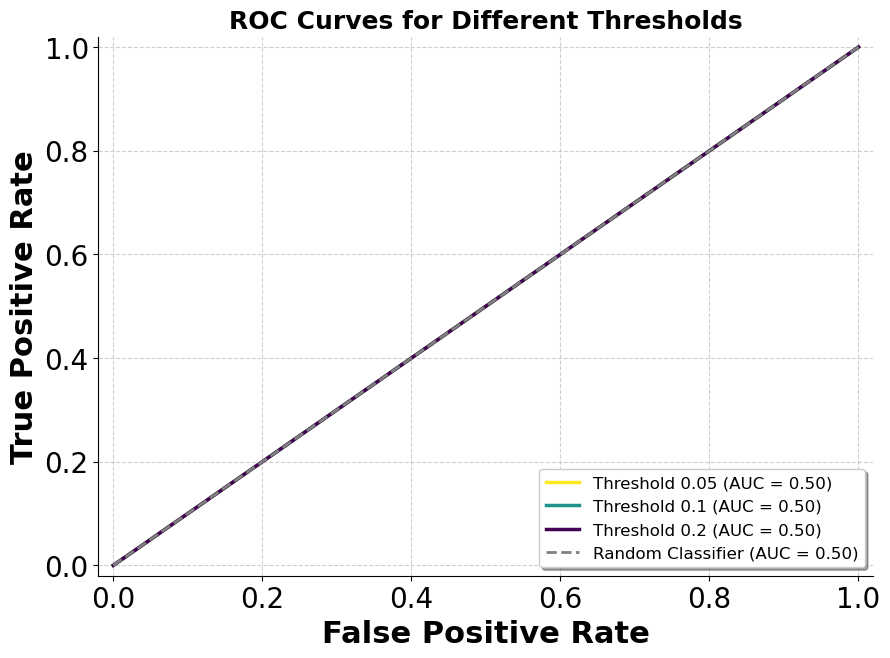

In [66]:
from matplotlib import cm
from sklearn.metrics import auc

# Define colormap
#colors = cm.viridis(np.linspace(0, 1, len(roc_data)))
colors = cm.viridis(np.linspace(1, 0, len(roc_data)))

# Create a figure
plt.figure(figsize=(10, 7))

# Plot each ROC curve with a unique color
for (threshold, (fpr, tpr, _)), color in zip(roc_data.items(), colors):
    plt.plot(fpr, tpr, lw=2.5, color=color, label=f"Threshold {threshold} (AUC = {auc(fpr, tpr):.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="gray", label="Random Classifier (AUC = 0.50)")

# Customize the axes
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Labels & title
plt.xlabel("False Positive Rate", fontsize=22, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=22, fontweight="bold")
plt.title("ROC Curves for Different Thresholds", fontsize=18, fontweight="bold")

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust legend for better placement
plt.legend(loc="lower right", fontsize=12, frameon=True, fancybox=True, shadow=True)

# Remove unnecessary spines for a cleaner look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show the final plot
plt.show();

### predict Phylop

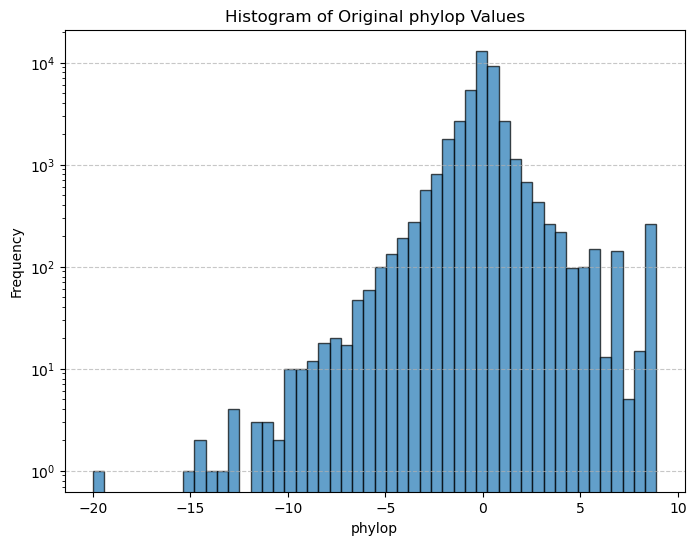

In [67]:
# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(df_clean["PhyloP_score"], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("phylop")
plt.ylabel("Frequency")
plt.title("Histogram of Original phylop Values")
plt.yscale("log")  # Log scale for better visualization of distribution
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show();

In [68]:
df_clean["bPhylop"] = df_clean.PhyloP_score > -2.5

In [69]:
# Define features:
feature_names = ['is_CpG','is_protein_coding', 'experimental_ln_FI']

In [70]:
one_hot_feature_names = df_clean.columns[7:31].tolist()
all_features = feature_names + one_hot_feature_names  # Combine named & indexed features
all_features

['is_CpG',
 'is_protein_coding',
 'experimental_ln_FI',
 'gene_type_TEC',
 'gene_type_lncRNA',
 'gene_type_miRNA',
 'gene_type_misc_RNA',
 'gene_type_polymorphic_pseudogene',
 'gene_type_processed_pseudogene',
 'gene_type_protein_coding',
 'gene_type_rRNA_pseudogene',
 'gene_type_snRNA',
 'gene_type_snoRNA',
 'gene_type_transcribed_processed_pseudogene',
 'gene_type_transcribed_unitary_pseudogene',
 'gene_type_transcribed_unprocessed_pseudogene',
 'gene_type_unitary_pseudogene',
 'gene_type_unprocessed_pseudogene',
 'ccre_type_CTCF-only,CTCF-bound',
 'ccre_type_DNase-H3K4me3',
 'ccre_type_DNase-H3K4me3,CTCF-bound',
 'ccre_type_PLS',
 'ccre_type_PLS,CTCF-bound',
 'ccre_type_dELS',
 'ccre_type_dELS,CTCF-bound',
 'ccre_type_pELS',
 'ccre_type_pELS,CTCF-bound']

In [71]:
feature_indexes = list(range(7, 32))   # for one hot encoded
df_clean.iloc[:, feature_indexes] = df_clean.iloc[:, feature_indexes].astype(int)
df_clean

,sequence_context,seqnames,start,PhyloP_score,is_CpG,experimental_ln_FI,label_counts,gene_type_TEC,gene_type_lncRNA,gene_type_miRNA,...,"ccre_type_PLS,CTCF-bound",ccre_type_dELS,"ccre_type_dELS,CTCF-bound",ccre_type_pELS,"ccre_type_pELS,CTCF-bound",is_protein_coding,MAF_log,MAF_original,bPhylop,bMAF
0,AACAAAA,1,99267131,-0.055,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-4.829928,0.007987,True,0
1,AACAAAA,1,161294824,-1.399,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-8.518194,0.000200,True,0
2,AACAAAA,1,169903374,-1.708,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-7.825297,0.000400,True,0
3,AACAAAA,1,82064640,-0.639,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-8.518194,0.000200,True,0
4,AACAAAA,1,153830104,-1.016,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-7.825297,0.000400,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40665,TTCTTTT,1,156911602,-0.868,0,6.576470,10,0,0,0,...,0,0,0,0,0,1,-3.874241,0.020770,True,0
40666,TTCTTTT,1,26226773,-1.496,0,6.576470,10,0,0,0,...,0,0,0,0,0,1,-0.760356,0.467500,True,1
40667,TTCTTTT,1,229773166,0.243,0,6.576470,10,0,0,0,...,0,0,0,0,0,1,-8.518194,0.000200,True,0
40668,TTCTTTT,1,106091814,-1.192,0,6.576470,10,0,1,0,...,0,0,0,0,0,1,-1.221119,0.294900,True,1


In [72]:
X = df_clean[all_features]
y = df_clean['bPhylop']  
#X, y

Train-test

In [73]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [74]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (32536, 27)
y_train shape: (32536,)


In [75]:
# Count True and False values in df_clean['bMAF']
true_count = df_clean['bPhylop'].sum()  # Sum of True values (since True = 1, False = 0)
false_count = len(df_clean) - true_count  # Total rows minus True count

# Print results
print(f"True count: {true_count}")
print(f"False count: {false_count}")

True count: 38971
False count: 1699


In [76]:
ratio = len(df_clean[df_clean['bPhylop'] == True]) / len(df_clean[df_clean['bPhylop'] == False])  
model = XGBClassifier(random_state=42,
                      scale_pos_weight=ratio)  # Adjust weight dynamically

In [77]:
ratio

22.937610359034725

In [78]:
# Train the model
model.fit(X_train, y_train)

# Predict probabilities & binary class labels
y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
y_pred = model.predict(X_test)  # Get binary predictions

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [79]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# Print classification report
print(classification_report(y_test, y_pred))

# Compute AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

       False       0.17      0.00      0.01       340
        True       0.96      1.00      0.98      7794

    accuracy                           0.96      8134
   macro avg       0.56      0.50      0.49      8134
weighted avg       0.93      0.96      0.94      8134

AUC-ROC Score: 0.7034


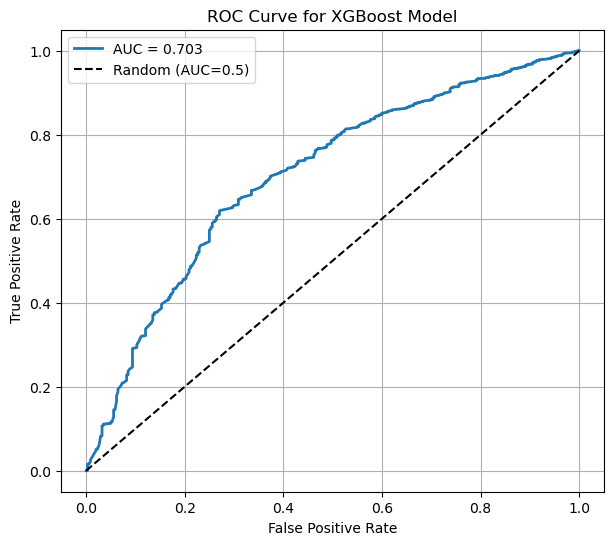

In [80]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend()
plt.grid()
plt.show();

In [81]:
# Store results in dictionary
model_name = "phylop_tminus2.5_NoGrid"  # Change this for different models
model_results[model_name] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": roc_auc}

# Save as a JSON file
results_file = "phylop_tminus2.5_NoGrid.json"

with open(results_file, "w") as f:
    json.dump(model_results, f, indent=4)
    
print(f"ROC details for {model_name} saved successfully!")

ROC details for phylop_tminus2.5_NoGrid saved successfully!


### different phylop threshold

In [82]:
df_clean["bPhylop"] = df_clean.PhyloP_score > 0

In [83]:
X = df_clean[all_features]
y = df_clean['bPhylop']  
#X, y

Train-test

In [84]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [85]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (32536, 27)
y_train shape: (32536,)


In [86]:
# Count True and False values in df_clean['bMAF']
true_count = df_clean['bPhylop'].sum()  # Sum of True values (since True = 1, False = 0)
false_count = len(df_clean) - true_count  # Total rows minus True count

# Print results
print(f"True count: {true_count}")
print(f"False count: {false_count}")

True count: 21583
False count: 19087


In [87]:
ratio = len(df_clean[df_clean['bPhylop'] == True]) / len(df_clean[df_clean['bPhylop'] == False])  
model = XGBClassifier(random_state=42,
                      scale_pos_weight=ratio)  # Adjust weight dynamically

In [88]:
ratio

1.1307696337821553

In [89]:
# Train the model
model.fit(X_train, y_train)

# Predict probabilities & binary class labels
y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
y_pred = model.predict(X_test)  # Get binary predictions

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [90]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# Print classification report
print(classification_report(y_test, y_pred))

# Compute AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

       False       0.60      0.43      0.50      3817
        True       0.60      0.74      0.66      4317

    accuracy                           0.60      8134
   macro avg       0.60      0.59      0.58      8134
weighted avg       0.60      0.60      0.58      8134

AUC-ROC Score: 0.6062


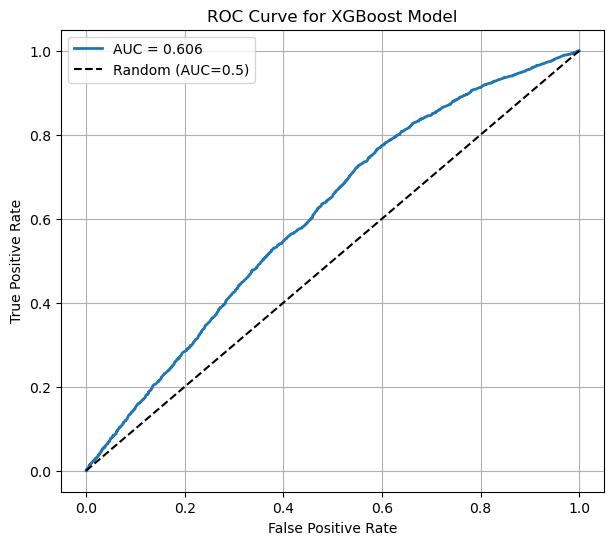

In [91]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend()
plt.grid()
plt.show();

In [92]:
# Store results in dictionary
model_name = "phylop_t0_NoGrid"  # Change this for different models
model_results[model_name] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": roc_auc}

# Save as a JSON file
results_file = "phylop_t0_NoGrid.json"

with open(results_file, "w") as f:
    json.dump(model_results, f, indent=4)
    
print(f"ROC details for {model_name} saved successfully!")

ROC details for phylop_t0_NoGrid saved successfully!


### Grid search

In [93]:
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'max_depth': [3, 5, 7],             # Tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Step size for each tree
    'subsample': [0.8, 1.0],            # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],     # Fraction of features used per tree
    'reg_alpha': [0, 0.1, 1],           # L1 regularization?
    'reg_lambda': [1, 10],              # L2 regularization?
}

In [94]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=3,                             # 5-fold cross-validation
    verbose=3,                        # Verbosity level for progress updates
    n_jobs=-1                         # Use all available CPUs
)

In [95]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, 
                                   n_iter=100, cv=3, verbose=1, n_jobs=-1)

In [96]:
# Fit the Randomized Search model to training data
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 10],
                                        'subsample': [0.8, 1.0]},
                   verbose=1)

In [100]:
# Print the best parameters found
print("Best hyperparameters:", random_search.best_params_)

Best hyperparameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [98]:
best_model = random_search.best_estimator_

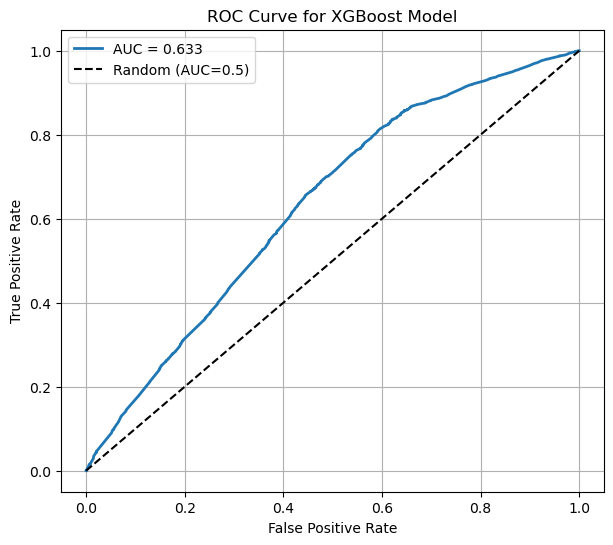

In [99]:
# Train the model
best_model.fit(X_train, y_train)

y_pred_probs = best_model.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend()
plt.grid()
plt.show();

### Running best hyper parameters on 3 different threshold

In [101]:
df_clean

,sequence_context,seqnames,start,PhyloP_score,is_CpG,experimental_ln_FI,label_counts,gene_type_TEC,gene_type_lncRNA,gene_type_miRNA,...,"ccre_type_PLS,CTCF-bound",ccre_type_dELS,"ccre_type_dELS,CTCF-bound",ccre_type_pELS,"ccre_type_pELS,CTCF-bound",is_protein_coding,MAF_log,MAF_original,bPhylop,bMAF
0,AACAAAA,1,99267131,-0.055,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-4.829928,0.007987,False,0
1,AACAAAA,1,161294824,-1.399,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-8.518194,0.000200,False,0
2,AACAAAA,1,169903374,-1.708,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-7.825297,0.000400,False,0
3,AACAAAA,1,82064640,-0.639,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-8.518194,0.000200,False,0
4,AACAAAA,1,153830104,-1.016,0,7.090493,10,0,0,0,...,0,0,0,0,0,1,-7.825297,0.000400,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40665,TTCTTTT,1,156911602,-0.868,0,6.576470,10,0,0,0,...,0,0,0,0,0,1,-3.874241,0.020770,False,0
40666,TTCTTTT,1,26226773,-1.496,0,6.576470,10,0,0,0,...,0,0,0,0,0,1,-0.760356,0.467500,False,1
40667,TTCTTTT,1,229773166,0.243,0,6.576470,10,0,0,0,...,0,0,0,0,0,1,-8.518194,0.000200,True,0
40668,TTCTTTT,1,106091814,-1.192,0,6.576470,10,0,1,0,...,0,0,0,0,0,1,-1.221119,0.294900,False,1


In [102]:
thresholds = [-2.5, -1, 0]  # Define your thresholds
results = []  # To store evaluation metrics
roc_data = {}  # To store ROC curves for each threshold

for threshold in thresholds:
    print(f"\nRunning classifier for threshold: {threshold}")
    
    # Create binary labels
    df_clean['bPhylop'] = (df_clean['PhyloP_score'] >= threshold).astype(int)
    df = df_clean.dropna(subset=['bPhylop']).copy()

    X = df[all_features]
    y = df["bPhylop"].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train XGBoost classifier
    model = XGBClassifier(
        subsample= 0.8, 
        reg_lambda= 1, 
        reg_alpha= 0.1, 
        n_estimators= 100, 
        max_depth= 3, 
        learning_rate= 0.01, 
        colsample_bytree= 0.8,
        scale_pos_weight=len(df_clean[df_clean['bPhylop'] == False]) / len(df_clean[df_clean['bPhylop'] == True])   # Adjust for imbalance
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    roc_auc = auc(*roc_curve(y_test, y_pred_prob)[:2])
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report["accuracy"]
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    results.append([threshold, roc_auc, accuracy, precision, recall])
    roc_data[threshold] = roc_curve(y_test, y_pred_prob)
    
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Threshold", "AUC", "Accuracy", "Precision", "Recall"])


Running classifier for threshold: -2.5


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


Running classifier for threshold: -1


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


Running classifier for threshold: 0


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [103]:
results_df

,Threshold,AUC,Accuracy,Precision,Recall
0,-2.5,0.747373,0.721908,0.982218,0.722864
1,-1.0,0.681387,0.725104,0.906125,0.753592
2,0.0,0.623823,0.622326,0.610120,0.816575


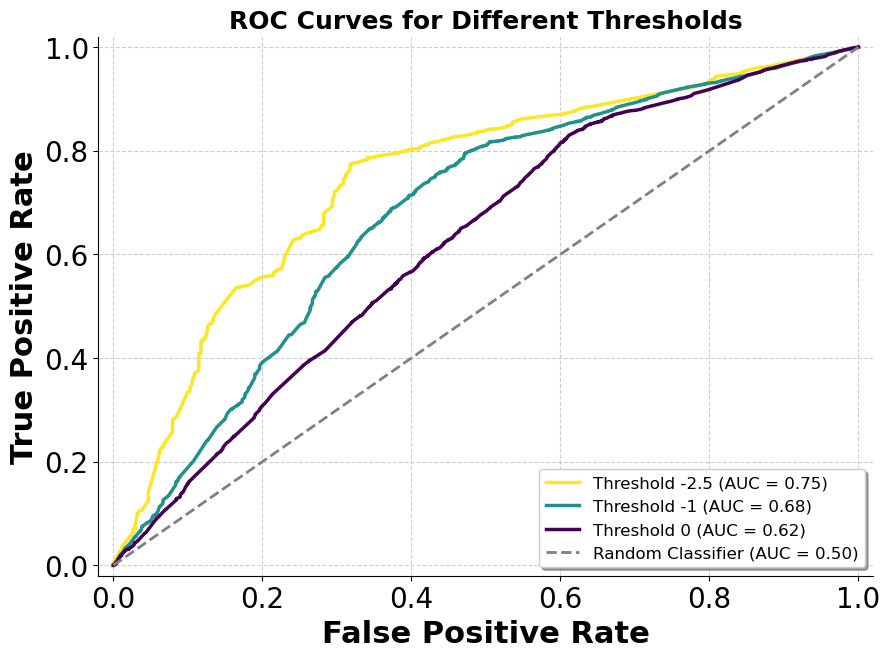

In [104]:
from matplotlib import cm
from sklearn.metrics import auc

# Define colormap
#colors = cm.viridis(np.linspace(0, 1, len(roc_data)))
colors = cm.viridis(np.linspace(1, 0, len(roc_data)))

# Create a figure
plt.figure(figsize=(10, 7))

# Plot each ROC curve with a unique color
for (threshold, (fpr, tpr, _)), color in zip(roc_data.items(), colors):
    plt.plot(fpr, tpr, lw=2.5, color=color, label=f"Threshold {threshold} (AUC = {auc(fpr, tpr):.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="gray", label="Random Classifier (AUC = 0.50)")

# Customize the axes
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Labels & title
plt.xlabel("False Positive Rate", fontsize=22, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=22, fontweight="bold")
plt.title("ROC Curves for Different Thresholds", fontsize=18, fontweight="bold")

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust legend for better placement
plt.legend(loc="lower right", fontsize=12, frameon=True, fancybox=True, shadow=True)

# Remove unnecessary spines for a cleaner look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show the final plot
plt.show();

In [105]:
roc_data

{-2.5: (array([0.        , 0.        , 0.        , 0.        , 0.01176471,
         0.01176471, 0.01176471, 0.01176471, 0.01176471, 0.01176471,
         0.02058824, 0.02058824, 0.02058824, 0.02058824, 0.02647059,
         0.02647059, 0.02647059, 0.02647059, 0.02647059, 0.02647059,
         0.02647059, 0.02941176, 0.02941176, 0.02941176, 0.02941176,
         0.02941176, 0.03235294, 0.03529412, 0.03529412, 0.03823529,
         0.04705882, 0.04705882, 0.04705882, 0.04705882, 0.04705882,
         0.04705882, 0.04705882, 0.04705882, 0.04705882, 0.04705882,
         0.04705882, 0.04705882, 0.04705882, 0.04705882, 0.04705882,
         0.05      , 0.05      , 0.06176471, 0.06176471, 0.06176471,
         0.06176471, 0.06176471, 0.06176471, 0.06176471, 0.06176471,
         0.06176471, 0.06470588, 0.06470588, 0.06470588, 0.06764706,
         0.06764706, 0.06764706, 0.06764706, 0.06764706, 0.06764706,
         0.06764706, 0.07058824, 0.07058824, 0.07058824, 0.07058824,
         0.07058824, 0.07058

In [106]:
import json

# Define the file name where we will save the ROC data
roc_file = "phylop_roc_tminus2.5_1_0_afterGrid.json"

# Convert existing roc_data dictionary to a JSON-friendly format
roc_data_json = {
    str(threshold): {
        "fpr": fpr.tolist(),  # Convert numpy array to list
        "tpr": tpr.tolist(),
        "roc_auc": auc(fpr, tpr)
    }
    for threshold, (fpr, tpr, _) in roc_data.items()
}

# Load existing ROC data (if available) to avoid overwriting
try:
    with open(roc_file, "r") as f:
        saved_roc_data = json.load(f)
except FileNotFoundError:
    saved_roc_data = {}

# Merge old and new data
saved_roc_data.update(roc_data_json)

# Save all ROC data to JSON file
with open(roc_file, "w") as f:
    json.dump(saved_roc_data, f, indent=4)

print("All ROC curves saved successfully!")


All ROC curves saved successfully!


### Use Enformer

In [107]:
import torch
import numpy as np
import pandas as pd
import os

In [108]:
os.chdir('/home/projects/aafek/nogal/noga_project/AI_hub/Repair-mutation project/Data')

In [109]:
# Load the saved predictions
predictions = np.load("merged_pretrainedEnformerPredictions_10repsPerContext_447row.npy")

# Check the type of data
print(type(predictions))  # Should be a list of tensors

<class 'numpy.ndarray'>


In [110]:
# Check the number of saved predictions
print("Number of predictions:", len(predictions))

# Check the shape of the first prediction
print("Shape of first prediction:", predictions[0].shape)

Number of predictions: 40670
Shape of first prediction: (5313,)


In [111]:
# Convert to Pandas DataFrame for easy analysis
df = pd.DataFrame(predictions)

In [112]:
import pandas as pd
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/0.5/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.shape  # (5313, 8) With rows match output shape above.

(5313, 8)

In [113]:
df_targets

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion
3,3,0,ENCFF463ZLQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:Ishikawa treated with 0.02% dimethyl sul...
4,4,0,ENCFF890OGQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:GM03348
...,...,...,...,...,...,...,...,...
5308,5308,0,CNhs14239,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:epithelioid sarcoma cell line:HS-ES-2R
5309,5309,0,CNhs14240,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:squamous cell lung carcinoma cell line:RE...
5310,5310,0,CNhs14241,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:gastric cancer cell line:GSS
5311,5311,0,CNhs14244,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:carcinoid cell line:NCI-H727


In [114]:
labels = pd.read_csv("equal_contexts_sampling_10reps_3101025.csv")  # Replace with your actual file path
labels

,sequence_context,seqnames,start,CAF,COMMON,TOPMED,FILTER,PhyloP_score,is_CpG,gene_type,protein_id,ccre_type,log.Intensity..RU.,MAF,label_counts
0,AACAAAA,1,99267131,"0.992,0.007987",1.0,"0.99168577981651376,0.00831422018348623",.,-0.055,0,protein_coding,ENSP00000359204.4,0,7.090493,0.007987,10
1,AACAAAA,1,161294824,"0.9998,0.0001997",0.0,"0.99998407237512742,0.00001592762487257",.,-1.399,0,0,0,0,7.090493,0.000200,10
2,AACAAAA,1,169903374,"0.9996,0.0003994",0.0,"0.99983275993883792,0.00016724006116207",.,-1.708,0,0,0,0,7.090493,0.000399,10
3,AACAAAA,1,82064640,"0.9998,0.0001997",0.0,"0.99995221712538226,0.00004778287461773",.,-0.639,0,0,0,0,7.090493,0.000200,10
4,AACAAAA,1,153830104,"0.9996,0.0003994",1.0,NaN,.,-1.016,0,protein_coding,ENSP00000490635.1,0,7.090493,0.000399,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40665,TTCTTTT,1,156911602,"0.9792,0.02077",1.0,"0.97483435270132517,0.02516564729867482",.,-0.868,0,protein_coding,0,0,6.576470,0.020770,10
40666,TTCTTTT,1,26226773,"0.5325,0.4675",1.0,"0.47396629714576962,0.52603370285423037",.,-1.496,0,transcribed_unprocessed_pseudogene,0,0,6.576470,0.467500,10
40667,TTCTTTT,1,229773166,"0.9998,0.0001997",0.0,"0.99982479612640163,0.00017520387359836",.,0.243,0,0,0,0,6.576470,0.000200,10
40668,TTCTTTT,1,106091814,"0.7051,0.2949",1.0,"0.92422432466870540,0.07577567533129459",.,-1.192,0,lncRNA,0,0,6.576470,0.294900,10


In [115]:
labels_filtered = labels[["sequence_context", 
                          "PhyloP_score", 
                          "log.Intensity..RU.",
                         "MAF"]]  # Replace with actual column names
labels_filtered

,sequence_context,PhyloP_score,log.Intensity..RU.,MAF
0,AACAAAA,-0.055,7.090493,0.007987
1,AACAAAA,-1.399,7.090493,0.000200
2,AACAAAA,-1.708,7.090493,0.000399
3,AACAAAA,-0.639,7.090493,0.000200
4,AACAAAA,-1.016,7.090493,0.000399
...,...,...,...,...
40665,TTCTTTT,-0.868,6.576470,0.020770
40666,TTCTTTT,-1.496,6.576470,0.467500
40667,TTCTTTT,0.243,6.576470,0.000200
40668,TTCTTTT,-1.192,6.576470,0.294900


In [116]:
labels_filtered.rename(columns={"log.Intensity..RU.": "Experimental_ln_FI"}, inplace=True)
labels_filtered


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,sequence_context,PhyloP_score,Experimental_ln_FI,MAF
0,AACAAAA,-0.055,7.090493,0.007987
1,AACAAAA,-1.399,7.090493,0.000200
2,AACAAAA,-1.708,7.090493,0.000399
3,AACAAAA,-0.639,7.090493,0.000200
4,AACAAAA,-1.016,7.090493,0.000399
...,...,...,...,...
40665,TTCTTTT,-0.868,6.576470,0.020770
40666,TTCTTTT,-1.496,6.576470,0.467500
40667,TTCTTTT,0.243,6.576470,0.000200
40668,TTCTTTT,-1.192,6.576470,0.294900


combine labels and precitions

In [117]:
combined_df = pd.concat([labels_filtered, df], axis=1)
combined_df

,sequence_context,PhyloP_score,Experimental_ln_FI,MAF,0,1,2,3,4,5,...,5303,5304,5305,5306,5307,5308,5309,5310,5311,5312
0,AACAAAA,-0.055,7.090493,0.007987,0.127627,0.143471,0.126784,0.092656,0.321803,0.163509,...,0.163171,0.172749,0.056202,0.042129,0.003545,0.000874,0.003452,0.003941,0.022684,0.006992
1,AACAAAA,-1.399,7.090493,0.000200,0.100846,0.107022,0.088973,0.108965,0.073562,0.054727,...,0.135254,0.041598,0.014146,0.009048,0.004031,0.001411,0.001890,0.002753,0.008369,0.007336
2,AACAAAA,-1.708,7.090493,0.000399,0.051121,0.059828,0.033739,0.073273,0.043251,0.036652,...,0.055574,0.014426,0.005895,0.003233,0.002179,0.000890,0.001929,0.001393,0.006260,0.005055
3,AACAAAA,-0.639,7.090493,0.000200,0.082305,0.069584,0.067575,0.133809,0.076870,0.081940,...,0.087218,0.022855,0.009846,0.004991,0.004179,0.001591,0.001899,0.003287,0.007815,0.008273
4,AACAAAA,-1.016,7.090493,0.000399,0.034298,0.025548,0.016586,0.037533,0.023947,0.019229,...,0.081810,0.021077,0.008261,0.009749,0.004327,0.001439,0.002769,0.003755,0.018036,0.013414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40665,TTCTTTT,-0.868,6.576470,0.020770,0.023266,0.021038,0.011399,0.031848,0.019836,0.014148,...,0.076662,0.023517,0.009070,0.011560,0.002592,0.001435,0.001761,0.002384,0.010660,0.005361
40666,TTCTTTT,-1.496,6.576470,0.467500,0.099230,0.096344,0.054917,0.136455,0.068017,0.050961,...,0.223060,0.050339,0.020252,0.011784,0.004516,0.002917,0.004233,0.003333,0.016108,0.014108
40667,TTCTTTT,0.243,6.576470,0.000200,0.095211,0.086082,0.066853,0.113715,0.067449,0.061932,...,0.071951,0.018223,0.007752,0.005460,0.003072,0.002148,0.002067,0.003067,0.008921,0.008486
40668,TTCTTTT,-1.192,6.576470,0.294900,0.079697,0.077405,0.047421,0.110086,0.059683,0.045048,...,0.349928,0.100362,0.037995,0.025069,0.004055,0.002277,0.002394,0.002792,0.016544,0.010428


In [118]:
combined_numeric_df = combined_df.drop(columns=["sequence_context"])
combined_numeric_df

,PhyloP_score,Experimental_ln_FI,MAF,0,1,2,3,4,5,6,...,5303,5304,5305,5306,5307,5308,5309,5310,5311,5312
0,-0.055,7.090493,0.007987,0.127627,0.143471,0.126784,0.092656,0.321803,0.163509,0.439216,...,0.163171,0.172749,0.056202,0.042129,0.003545,0.000874,0.003452,0.003941,0.022684,0.006992
1,-1.399,7.090493,0.000200,0.100846,0.107022,0.088973,0.108965,0.073562,0.054727,0.096203,...,0.135254,0.041598,0.014146,0.009048,0.004031,0.001411,0.001890,0.002753,0.008369,0.007336
2,-1.708,7.090493,0.000399,0.051121,0.059828,0.033739,0.073273,0.043251,0.036652,0.076404,...,0.055574,0.014426,0.005895,0.003233,0.002179,0.000890,0.001929,0.001393,0.006260,0.005055
3,-0.639,7.090493,0.000200,0.082305,0.069584,0.067575,0.133809,0.076870,0.081940,0.106658,...,0.087218,0.022855,0.009846,0.004991,0.004179,0.001591,0.001899,0.003287,0.007815,0.008273
4,-1.016,7.090493,0.000399,0.034298,0.025548,0.016586,0.037533,0.023947,0.019229,0.029286,...,0.081810,0.021077,0.008261,0.009749,0.004327,0.001439,0.002769,0.003755,0.018036,0.013414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40665,-0.868,6.576470,0.020770,0.023266,0.021038,0.011399,0.031848,0.019836,0.014148,0.026422,...,0.076662,0.023517,0.009070,0.011560,0.002592,0.001435,0.001761,0.002384,0.010660,0.005361
40666,-1.496,6.576470,0.467500,0.099230,0.096344,0.054917,0.136455,0.068017,0.050961,0.100958,...,0.223060,0.050339,0.020252,0.011784,0.004516,0.002917,0.004233,0.003333,0.016108,0.014108
40667,0.243,6.576470,0.000200,0.095211,0.086082,0.066853,0.113715,0.067449,0.061932,0.089391,...,0.071951,0.018223,0.007752,0.005460,0.003072,0.002148,0.002067,0.003067,0.008921,0.008486
40668,-1.192,6.576470,0.294900,0.079697,0.077405,0.047421,0.110086,0.059683,0.045048,0.079040,...,0.349928,0.100362,0.037995,0.025069,0.004055,0.002277,0.002394,0.002792,0.016544,0.010428


### Avoid duplicates in Enformer

In [119]:
enformer_features = combined_df.iloc[:,4:]
enformer_features

,0,1,2,3,4,5,6,7,8,9,...,5303,5304,5305,5306,5307,5308,5309,5310,5311,5312
0,0.127627,0.143471,0.126784,0.092656,0.321803,0.163509,0.439216,0.401420,0.290733,0.113508,...,0.163171,0.172749,0.056202,0.042129,0.003545,0.000874,0.003452,0.003941,0.022684,0.006992
1,0.100846,0.107022,0.088973,0.108965,0.073562,0.054727,0.096203,0.079994,0.078643,0.097768,...,0.135254,0.041598,0.014146,0.009048,0.004031,0.001411,0.001890,0.002753,0.008369,0.007336
2,0.051121,0.059828,0.033739,0.073273,0.043251,0.036652,0.076404,0.060287,0.064445,0.056953,...,0.055574,0.014426,0.005895,0.003233,0.002179,0.000890,0.001929,0.001393,0.006260,0.005055
3,0.082305,0.069584,0.067575,0.133809,0.076870,0.081940,0.106658,0.090583,0.103986,0.062511,...,0.087218,0.022855,0.009846,0.004991,0.004179,0.001591,0.001899,0.003287,0.007815,0.008273
4,0.034298,0.025548,0.016586,0.037533,0.023947,0.019229,0.029286,0.021662,0.026051,0.017304,...,0.081810,0.021077,0.008261,0.009749,0.004327,0.001439,0.002769,0.003755,0.018036,0.013414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40665,0.023266,0.021038,0.011399,0.031848,0.019836,0.014148,0.026422,0.015591,0.020464,0.019834,...,0.076662,0.023517,0.009070,0.011560,0.002592,0.001435,0.001761,0.002384,0.010660,0.005361
40666,0.099230,0.096344,0.054917,0.136455,0.068017,0.050961,0.100958,0.061241,0.071768,0.066359,...,0.223060,0.050339,0.020252,0.011784,0.004516,0.002917,0.004233,0.003333,0.016108,0.014108
40667,0.095211,0.086082,0.066853,0.113715,0.067449,0.061932,0.089391,0.062763,0.073103,0.067794,...,0.071951,0.018223,0.007752,0.005460,0.003072,0.002148,0.002067,0.003067,0.008921,0.008486
40668,0.079697,0.077405,0.047421,0.110086,0.059683,0.045048,0.079040,0.052161,0.063881,0.066556,...,0.349928,0.100362,0.037995,0.025069,0.004055,0.002277,0.002394,0.002792,0.016544,0.010428


In [120]:
# Check for duplicates in column names
duplicates = enformer_features.columns[enformer_features.columns.duplicated()]
print("Duplicate column names:", duplicates)

Duplicate column names: Index([], dtype='object')


In [121]:
enformer_features.columns = [f"{col}_{i}" if enformer_features.columns.tolist().count(col) > 1 else col
                   for i, col in enumerate(enformer_features.columns)]

In [122]:
# Check for duplicates in column names
duplicates = enformer_features.columns[enformer_features.columns.duplicated()]
print("Duplicate column names:", duplicates)

Duplicate column names: Index([], dtype='int64')


In [123]:
enformer_features.columns

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       5303, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 5311, 5312],
      dtype='int64', length=5313)

In [124]:
TDG_feature = combined_df.iloc[:,2:3].columns.tolist() 
TDG_feature

['Experimental_ln_FI']

In [125]:
# Convert column index to list
feature_list = enformer_features.columns.tolist()  # Ensure it's a Python list
#feature_list

In [126]:
df_clean["bPhylop"] = df_clean.PhyloP_score > 0

In [127]:
X = combined_df[feature_list + TDG_feature]
y = df_clean['bPhylop']  
X, y

(              0         1         2         3         4         5         6  \
 0      0.127627  0.143471  0.126784  0.092656  0.321803  0.163509  0.439216   
 1      0.100846  0.107022  0.088973  0.108965  0.073562  0.054727  0.096203   
 2      0.051121  0.059828  0.033739  0.073273  0.043251  0.036652  0.076404   
 3      0.082305  0.069584  0.067575  0.133809  0.076870  0.081940  0.106658   
 4      0.034298  0.025548  0.016586  0.037533  0.023947  0.019229  0.029286   
 ...         ...       ...       ...       ...       ...       ...       ...   
 40665  0.023266  0.021038  0.011399  0.031848  0.019836  0.014148  0.026422   
 40666  0.099230  0.096344  0.054917  0.136455  0.068017  0.050961  0.100958   
 40667  0.095211  0.086082  0.066853  0.113715  0.067449  0.061932  0.089391   
 40668  0.079697  0.077405  0.047421  0.110086  0.059683  0.045048  0.079040   
 40669  0.589302  0.576371  0.222887  0.172508  0.274336  0.464775  0.309298   
 
               7         8         9  

Train-test

In [128]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [129]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (32536, 5314)
y_train shape: (32536,)


In [130]:
# Count True and False values in df_clean['bMAF']
true_count = df_clean['bPhylop'].sum()  # Sum of True values (since True = 1, False = 0)
false_count = len(df_clean) - true_count  # Total rows minus True count

# Print results
print(f"True count: {true_count}")
print(f"False count: {false_count}")

True count: 21583
False count: 19087


In [131]:
ratio = len(df_clean[df_clean['bPhylop'] == True]) / len(df_clean[df_clean['bPhylop'] == False])  
model = XGBClassifier(random_state=42,
                      scale_pos_weight=ratio)  # Adjust weight dynamically

In [132]:
ratio

1.1307696337821553

In [133]:
# Train the model
model.fit(X_train, y_train)

# Predict probabilities & binary class labels
y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
y_pred = model.predict(X_test)  # Get binary predictions

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [134]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# Print classification report
print(classification_report(y_test, y_pred))

# Compute AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

       False       0.55      0.47      0.51      3817
        True       0.59      0.67      0.62      4317

    accuracy                           0.57      8134
   macro avg       0.57      0.57      0.56      8134
weighted avg       0.57      0.57      0.57      8134

AUC-ROC Score: 0.5865


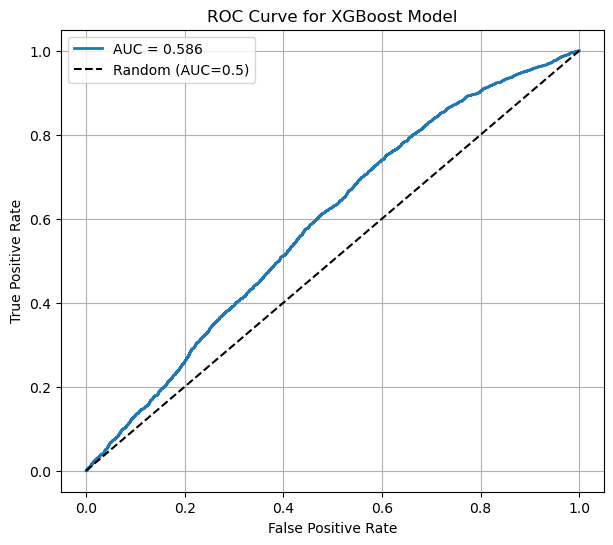

In [135]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend()
plt.grid()
plt.show();

In [137]:
# Store results in dictionary
model_name = "enformer_phylop_t0_NoGrid"  # Change this for different models
model_results[model_name] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": roc_auc}

# Save as a JSON file
results_file = "enformer_phylop_t0_NoGrid.json"

with open(results_file, "w") as f:
    json.dump(model_results, f, indent=4)
    
print(f"ROC details for {model_name} saved successfully!")

ROC details for enformer_phylop_t0_NoGrid saved successfully!


### Enformer predict MAF

In [193]:
df_clean["bMAF"] = df_clean.MAF_original > 0.001

In [194]:
X = combined_df[feature_list + TDG_feature]
y = df_clean['bMAF']  
X, y

(              0         1         2         3         4         5         6  \
 0      0.127627  0.143471  0.126784  0.092656  0.321803  0.163509  0.439216   
 1      0.100846  0.107022  0.088973  0.108965  0.073562  0.054727  0.096203   
 2      0.051121  0.059828  0.033739  0.073273  0.043251  0.036652  0.076404   
 3      0.082305  0.069584  0.067575  0.133809  0.076870  0.081940  0.106658   
 4      0.034298  0.025548  0.016586  0.037533  0.023947  0.019229  0.029286   
 ...         ...       ...       ...       ...       ...       ...       ...   
 40665  0.023266  0.021038  0.011399  0.031848  0.019836  0.014148  0.026422   
 40666  0.099230  0.096344  0.054917  0.136455  0.068017  0.050961  0.100958   
 40667  0.095211  0.086082  0.066853  0.113715  0.067449  0.061932  0.089391   
 40668  0.079697  0.077405  0.047421  0.110086  0.059683  0.045048  0.079040   
 40669  0.589302  0.576371  0.222887  0.172508  0.274336  0.464775  0.309298   
 
               7         8         9  

Train-test

In [195]:
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [196]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (32536, 5314)
y_train shape: (32536,)


In [197]:
# Count True and False values in df_clean['bMAF']
true_count = df_clean['bPhylop'].sum()  # Sum of True values (since True = 1, False = 0)
false_count = len(df_clean) - true_count  # Total rows minus True count

# Print results
print(f"True count: {true_count}")
print(f"False count: {false_count}")

True count: 21583
False count: 19087


In [202]:
ratio = len(df_clean[df_clean['bMAF'] == False]) / len(df_clean[df_clean['bMAF'] == True])  
model = XGBClassifier(random_state=42,
                      scale_pos_weight=ratio)  # Adjust weight dynamically

In [203]:
ratio

2.117908616988654

In [204]:
# Train the model
model.fit(X_train, y_train)

# Predict probabilities & binary class labels
y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of the positive class
y_pred = model.predict(X_test)  # Get binary predictions

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [205]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
# Print classification report
print(classification_report(y_test, y_pred))

# Compute AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {roc_auc:.4f}")

              precision    recall  f1-score   support

       False       0.68      0.83      0.75      5525
        True       0.33      0.18      0.24      2609

    accuracy                           0.62      8134
   macro avg       0.51      0.50      0.49      8134
weighted avg       0.57      0.62      0.58      8134

AUC-ROC Score: 0.5055


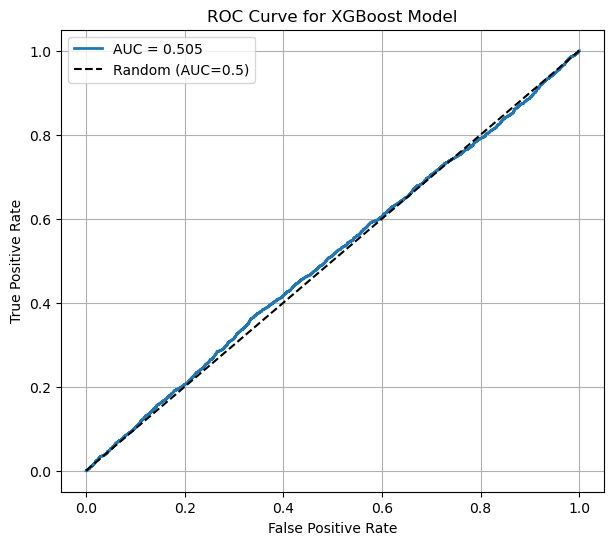

In [206]:
from sklearn.metrics import roc_curve, auc

y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probability of class 1

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend()
plt.grid()
plt.show();

In [207]:
# Store results in dictionary
model_name = "enformer_MAF_t0.001_NoGrid"  # Change this for different models
model_results[model_name] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": roc_auc}

# Save as a JSON file
results_file = "enformer_MAF_t0.001_NoGrid.json"

with open(results_file, "w") as f:
    json.dump(model_results, f, indent=4)
    
print(f"ROC details for {model_name} saved successfully!")

ROC details for enformer_MAF_t0.001_NoGrid saved successfully!


In [146]:
roc_data.values

<function dict.values>

In [150]:
import json

# Specify the JSON file path
json_file = "MAF_t0.1_NoGrid_roc.json"  # Replace with your actual file name

# Load the JSON file and extract model names (keys)
with open(json_file, "r") as f:
    data = json.load(f)

# Print available model names
print("Available models in the JSON file:")
for model_name in data.keys():
    print(f"- {model_name}")


Available models in the JSON file:
- MAF_t0.1_NoGrid


In [151]:
json_file = "MAF_t0.05_NoGrid.json"  # Replace with your actual file name

# Load the JSON file and extract model names (keys)
with open(json_file, "r") as f:
    data = json.load(f)

# Print available model names
print("Available models in the JSON file:")
for model_name in data.keys():
    print(f"- {model_name}")


Available models in the JSON file:
- MAF_t0.1_NoGrid
- MAF_t0.05_NoGrid


In [152]:
json_file = "phylop_roc_tminus2.5_1_0_afterGrid.json"  # Replace with your actual file name

# Load the JSON file and extract model names (keys)
with open(json_file, "r") as f:
    data = json.load(f)

# Print available model names
print("Available models in the JSON file:")
for model_name in data.keys():
    print(f"- {model_name}")

Available models in the JSON file:
- -2.5
- -1
- 0


In [153]:
json_file = "enformer_phylop_t0_NoGrid.json"  # Replace with your actual file name

# Load the JSON file and extract model names (keys)
with open(json_file, "r") as f:
    data = json.load(f)

# Print available model names
print("Available models in the JSON file:")
for model_name in data.keys():
    print(f"- {model_name}")

Available models in the JSON file:
- MAF_t0.1_NoGrid
- MAF_t0.05_NoGrid
- phylop_tminus2.5_NoGrid
- phylop_t0_NoGrid
- enformer_phylop_t0_NoGrid


In [208]:
json_file = "enformer_MAF_t0.001_NoGrid.json"  # Replace with your actual file name

# Load the JSON file and extract model names (keys)
with open(json_file, "r") as f:
    data = json.load(f)

# Print available model names
print("Available models in the JSON file:")
for model_name in data.keys():
    print(f"- {model_name}")


Available models in the JSON file:
- MAF_t0.1_NoGrid
- MAF_t0.05_NoGrid
- phylop_tminus2.5_NoGrid
- phylop_t0_NoGrid
- enformer_phylop_t0_NoGrid
- MAF_t0.001_NoGrid
- enformer_MAF_t0.001_NoGrid


### Plot everything together

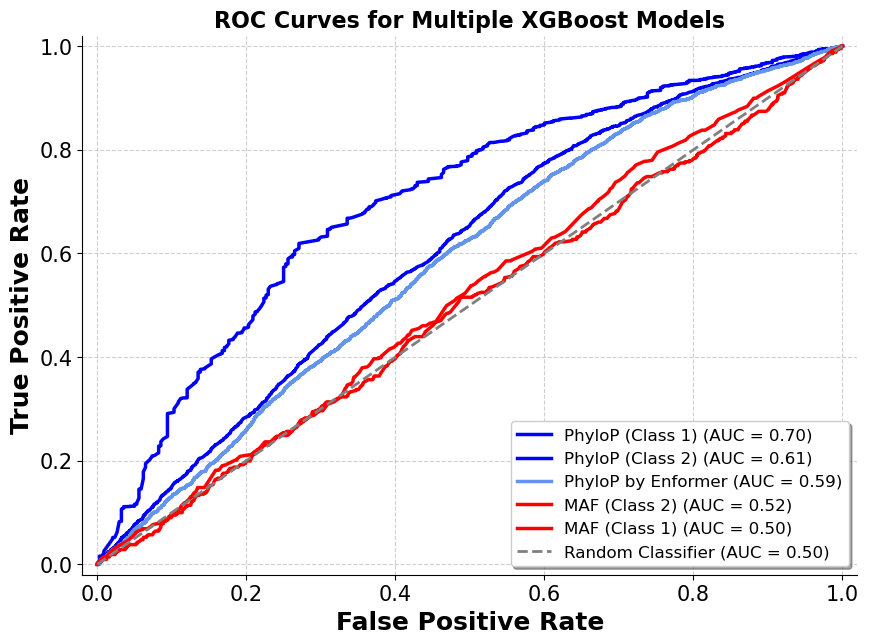

In [175]:
import json
import matplotlib.pyplot as plt
import numpy as np

# File paths
file_paths = [
    "enformer_phylop_t0_NoGrid.json"
]

# Define custom labels for legend
custom_labels = {
    "MAF_t0.1_NoGrid": "MAF (Class 1)",
    "MAF_t0.05_NoGrid": "MAF (Class 2)",
    "phylop_tminus2.5_NoGrid": "PhyloP (Class 1)",
    "phylop_t0_NoGrid": "PhyloP (Class 2)",
    "enformer_phylop_t0_NoGrid": "PhyloP by Enformer"
}

# Define custom colors for each model
custom_colors = {
    "MAF_t0.1_NoGrid": "red",
    "MAF_t0.05_NoGrid": "red",
    "phylop_tminus2.5_NoGrid": "blue",
    "phylop_t0_NoGrid": "blue",
    "enformer_phylop_t0_NoGrid": "cornflowerblue"
}

# Load all ROC data
roc_data = {}

for file in file_paths:
    with open(file, "r") as f:
        data = json.load(f)
        roc_data.update(data)  # Merge all into one dictionary

# Sort ROC data by AUC in descending order
sorted_roc_data = sorted(roc_data.items(), key=lambda x: x[1]["roc_auc"], reverse=True)

# Create figure
plt.figure(figsize=(10, 7))

# Plot each saved ROC curve with diagonal labels
for name, data in sorted_roc_data:
    custom_label = custom_labels.get(name, name)  # Use custom label if available
    color = custom_colors.get(name, "black")  # Default to black if not in dictionary

    plt.plot(data["fpr"], data["tpr"], lw=2.5, color=color, label=f"{custom_label} (AUC = {data['roc_auc']:.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="gray", label="Random Classifier (AUC = 0.50)")

# Customize axes
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Labels & title
plt.xlabel("False Positive Rate", fontsize=18, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=18, fontweight="bold")
plt.title("ROC Curves for Multiple XGBoost Models", fontsize=16, fontweight="bold")

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust legend order (highest AUC first)
plt.legend(loc="lower right", fontsize=12, frameon=True, fancybox=True, shadow=True)

# Remove unnecessary spines for a cleaner look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show plot
plt.show();


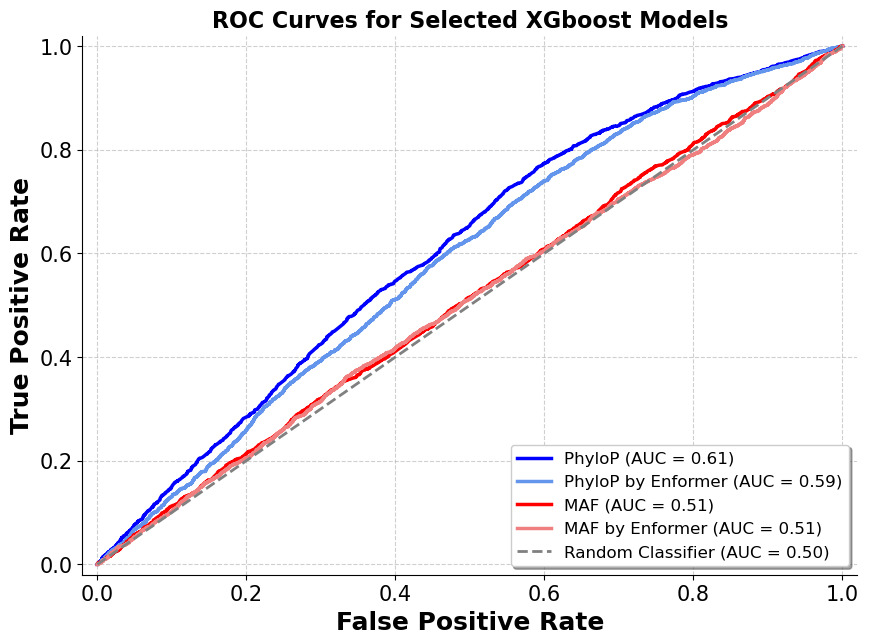

In [214]:
import json
import matplotlib.pyplot as plt
import numpy as np

# File path
json_file = "enformer_MAF_t0.001_NoGrid.json"

# Define models to include in the plot
selected_models = [
    "phylop_t0_NoGrid",
    "MAF_t0.001_NoGrid",
    "enformer_phylop_t0_NoGrid",
    "enformer_MAF_t0.001_NoGrid"
]

# Define custom labels for legend
custom_labels = {
    "phylop_t0_NoGrid": "PhyloP",
    "MAF_t0.001_NoGrid": "MAF",
    "enformer_phylop_t0_NoGrid": "PhyloP by Enformer",
    "enformer_MAF_t0.001_NoGrid": "MAF by Enformer",
}

# Define custom colors for each model
custom_colors = {
    "phylop_t0_NoGrid": "blue",
    "MAF_t0.001_NoGrid": "red",
    "enformer_phylop_t0_NoGrid": "cornflowerblue",
    "enformer_MAF_t0.001_NoGrid": "lightcoral"
}

# Load ROC data from JSON
with open(json_file, "r") as f:
    roc_data = json.load(f)

# Filter to keep only selected models
filtered_roc_data = {name: data for name, data in roc_data.items() if name in selected_models}

# Sort ROC data by AUC in descending order
sorted_roc_data = sorted(filtered_roc_data.items(), key=lambda x: x[1]["roc_auc"], reverse=True)

# Create figure
plt.figure(figsize=(10, 7))

# Plot each selected ROC curve
for name, data in sorted_roc_data:
    custom_label = custom_labels.get(name, name)  # Use custom label if available
    color = custom_colors.get(name, "black")  # Default to black if not in dictionary

    plt.plot(data["fpr"], data["tpr"], lw=2.5, color=color, label=f"{custom_label} (AUC = {data['roc_auc']:.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="gray", label="Random Classifier (AUC = 0.50)")

# Customize axes
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Labels & title
plt.xlabel("False Positive Rate", fontsize=18, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=18, fontweight="bold")
plt.title("ROC Curves for Selected XGboost Models", fontsize=16, fontweight="bold")

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust legend order (highest AUC first)
plt.legend(loc="lower right", fontsize=12, frameon=True, fancybox=True, shadow=True)

# Remove unnecessary spines for a cleaner look
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Show plot
plt.show();
